# Non polynomial fitting

### Introduction

So far we always considered the $f$ function in our system to be a polynomial:

$$\mathbf{x}_{t+1} = f(\mathbf{x}_t) \quad \text{ or } \quad \dot{\mathbf{x}} = f(\mathbf{x})$$ 

Where $\mathbf{x}$ is the state of the system.

The very natural question that arises from this approach is whether polynomials are adapted to learn the dynamics from the data. It seems that so far, our problem was not that the polynomials did not fit the data but rather that they did not learn the patterns that we wanted them to learn. 

In this post we will explore what happens when we use different functions.

### New formulation

So far we used the original approach as described in the paper [1] where the candidate functions depend only on the state. The coefficients for each of these functions are linear with respect to the loss thus allowing for a linear least squares fitting. If we want to add more elaborate functions we need to use coefficients that are non linear with respect to the loss and use non-linear least squares instead.

#### Rational functions

In order to keep this work simple and exploratory we will begin by considering rational functions. 

The first kind of functions that we can consider for our problem are rational functions. We would have $f(x) = \frac{p(x)}{q(x)}$ where $p$ and $q$ are polynomials. We now have a very simple curve-fitting problem that we can solve using `scipy.optimize`'s `curve_fit` method.

For the sake of simplicity we limit the maximum degree of the polynomials to 3:

$$f(x) = \frac{a + b x + c x^2 + d x^3}{1 + e x + f x^2 + g x^3}$$

Where $a, b, c, d, e, f, g$ are the parameters that we will optimize. In the experiment we also use a rational function with a polynomial of a maximum degree of 3 in the numerator and 2 in the denominator and another with 2 for the denominator and 2 for the numerator.

<!-- 
The second function that we can consider in a Gaussian bell. This will allow us to enforce that the model has a finite upper bound.

$$f(x) = a \cdot e^{c\cdot(x - b)^2}$$
 -->
 
 


In [2]:
from scipy.optimize import least_squares, minimize
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from ipywidgets import interact
import functools
%load_ext autoreload

In [3]:
%autoreload
import codebase
from codebase.sparse_regression import *
from codebase.utils import *

ds = CountryDataset()

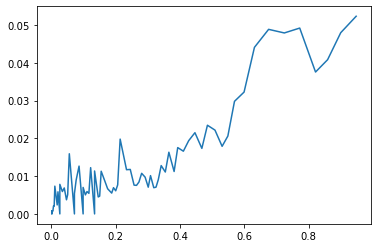

In [4]:
country = "Argentina"

country_data = ds.cumulative(country, rescaling=-1)
country_data = country_data[country_data > 0.001].reshape(-1, 1)

m2, m1 = make_targets(country_data)

# x0 = np.random.randn(5)
# split = 5

# res_1 = least_squares(lambda x: system(x, m2, m1, split), x0,)

# res_1.x

plt.plot(m1, m2-m1)

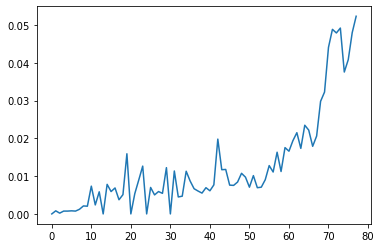

In [5]:
plt.plot( m2-m1)

c:\program files\python38\lib\site-packages\scipy\optimize\minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


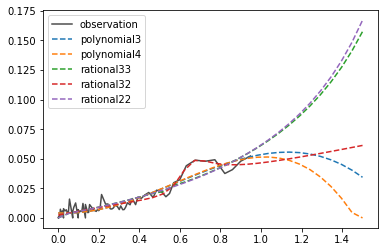

In [6]:
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

# functions

def polynomial3(x, a, b, c, d):
    return a + x*b + x*x*c + x*x*x*d

def polynomial4(x, a, b, c, d, e):
    return a + x*b + x*x*c + x*x*x*d + x*x*x*x*d

def rational33(x, a, b, c, d, e, f, g):
    return (a + x*b + x*x*c + x*x*x*d)/(1 + e*x + f*x*x + x*x*x*g)

def rational32(x, a, b, c, d, e, f):
    return (a + x*b + x*x*c + x*x*x*d)/(1 + e*x + f*x*x)

def rational22(x, a, b, c, e, f):
    return (a + x*b + x*x*c)/(1 + e*x + f*x*x)

def gaussian(x, a, b, c):
    return a * np.exp(c*((x - b))**2)

functions = [polynomial3, polynomial4, rational33, rational32, rational22]


xdata = m1.reshape(-1)
ydata = (m2-m1).reshape(-1)

sols = []

for f in functions:
    try:
        popt, pcov = curve_fit(f, xdata, ydata)
        sols.append(popt)
    except:
        sols.append(np.zeros(f.__code__.co_argcount - 1))
        
extrapolation = 1.5
t = np.linspace(0, extrapolation, 30)

plt.plot(xdata, ydata, 'k', label='observation', alpha=0.7)

for f, s in zip(functions, sols):
    plt.plot(t, np.clip(f(t, *s), a_min=0, a_max=np.inf), '--', label=f.__name__)
plt.legend()
plt.show()

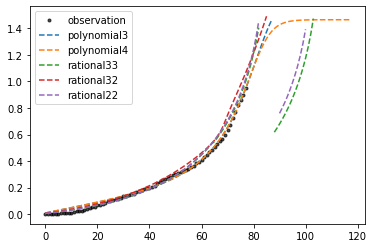

In [8]:
def generate(func, init, length):
    result = [func(init)]
    for k in range(length):
        result.append(func(result[k]))
    return np.array(result)

plt.plot(m1, 'k.', label='observation', alpha=0.7)

for f, s in zip(functions, sols):
    trajectory = generate(lambda x: f(x, *s) + x, 0.004, int(len(m1)*extrapolation))
    trajectory[(trajectory > 1.5) | (trajectory < 0)] = np.nan
    plt.plot(trajectory, '--', label=f.__name__)

plt.legend()
plt.show()

In [9]:
def show_comparison(country):
    
    country_data = ds.cumulative(country, rescaling=-1)
    country_data = country_data[country_data > 0.001]

    xdata = country_data[:-1]
    ydata = country_data[1:] - xdata
    
    extrapolation = 1.3
    t = np.linspace(0, extrapolation, 30)
    
    f, (ax1, ax2) = plt.subplots(2, 1, dpi=100, figsize=(10, 6))
    
    ax1.plot(xdata, ydata, 'k', label='observation', alpha=0.7)
    ax2.plot(xdata, 'k.', label='observation', alpha=0.7)

    for f in functions:
        try:
            s, _ = curve_fit(f, xdata, ydata)
        except:
            s = np.zeros(f.__code__.co_argcount - 1)
        vals = f(t, *s)
        vals[(vals > 1.5*max(ydata)) | (vals < -0.05)] = np.nan
            
        ax1.plot(t, vals, '--', label=f.__name__)
        
        initial_point = minimize(lambda x: (f(x, *s) - x)**2, 0).x + 0.01

        trajectory = generate(lambda x: f(x, *s) + x, initial_point, int(len(m1)*extrapolation))
        trajectory[(trajectory > 1.5) | (trajectory < 0)] = np.nan
        ax2.plot(trajectory, '--', label=f.__name__)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    
a = interact(show_comparison, country=ds.all_hopkins_countries(cases_cap=1000))

interactive(children=(Dropdown(description='country', options=('Afghanistan', 'Albania', 'Algeria', 'Argentina…

In [14]:
results = {}

convert_values = lambda vals: ['null' if np.isnan(v) else np.around(v, 7) for v in vals]

for country in tqdm(ds.all_hopkins_countries(cases_cap=2000)):
    current_result = {'derivated': {},
                      'integrated': {}}
    
    country_data = ds.cumulative(country, rescaling=-1)
    country_data = country_data[country_data > 0.001]

    xdata = country_data[:-1]
    ydata = country_data[1:] - xdata
    
    current_result['derivated']['original'] = convert_values(ydata)
    current_result['integrated']['original'] = convert_values(xdata)
    
    extrapolation = 1.3

    for f in functions:
        try:
            s, _ = curve_fit(f, xdata, ydata)
        except:
            s = np.zeros(f.__code__.co_argcount - 1)
        vals = f(xdata, *s)
        vals[(vals > 1.5*max(ydata)) | (vals < -0.05)] = np.nan
        current_result['derivated'][f.__name__] = convert_values(vals)
            
        initial_point = minimize(lambda x: (f(x, *s) - x)**2, 0).x + 0.01

        trajectory = generate(lambda x: f(x, *s) + x, initial_point, int(len(m1)*extrapolation))
        trajectory[(trajectory > 1.5) | (trajectory < 0)] = np.nan
        current_result['integrated'][f.__name__] = convert_values(trajectory.flatten())
        
    results[country] = current_result




  7%|█████▋                                                                             | 6/87 [00:00<00:06, 12.81it/s]<ipython-input-6-1448ec53b1dd>:7: RuntimeWarning: overflow encountered in multiply
  return a + x*b + x*x*c + x*x*x*d
<ipython-input-6-1448ec53b1dd>:7: RuntimeWarning: invalid value encountered in add
  return a + x*b + x*x*c + x*x*x*d
<ipython-input-14-afe5ffef897c>:32: RuntimeWarning: invalid value encountered in greater
  trajectory[(trajectory > 1.5) | (trajectory < 0)] = np.nan
<ipython-input-14-afe5ffef897c>:32: RuntimeWarning: invalid value encountered in less
  trajectory[(trajectory > 1.5) | (trajectory < 0)] = np.nan
<ipython-input-6-1448ec53b1dd>:10: RuntimeWarning: overflow encountered in multiply
  return a + x*b + x*x*c + x*x*x*d + x*x*x*x*d
<ipython-input-6-1448ec53b1dd>:10: RuntimeWarning: invalid value encountered in add
  return a + x*b + x*x*c + x*x*x*d + x*x*x*x*d
100%|█████████████████████████████████████████████████████████████████████████████████

In [15]:
results.keys()

dict_keys(['Afghanistan', 'Algeria', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Congo (Kinshasa)', "Cote d'Ivoire", 'Croatia', 'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Finland', 'France', 'Gabon', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Korea, South', 'Kuwait', 'Luxembourg', 'Malaysia', 'Mexico', 'Moldova', 'Morocco', 'Netherlands', 'Nigeria', 'North Macedonia', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia', 'Singapore', 'South Africa', 'Spain', 'Sudan', 'Sweden', 'Switzerland', 'Thailand', 'Turkey', 'Ukraine', 'United Arab Emirates

In [42]:
import json

with open('data/non-linear.json', 'w') as f:
    json.dump(results, f)

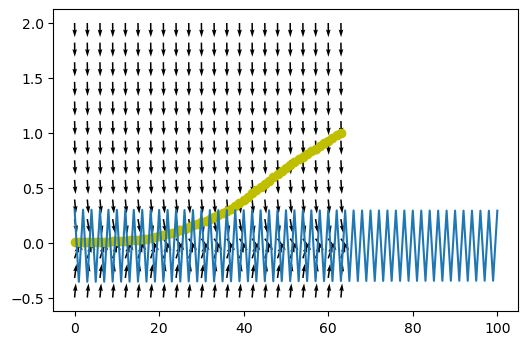

In [181]:
# country_data = ds.cumulative(country, rescaling=-1)
# country_data = country_data[country_data > 0.01].reshape(-1, 1)

# m2, m1 = make_targets(country_data)

# x0 = np.random.randn(4)
# split = 3

# res_1 = least_squares(lambda x: system(x, m2, m1, 3), x0)

T = np.arange(0, len(m1), 3)
C = np.linspace(-0.5, 2, 15)

U, V = np.zeros((len(C), len(T))), np.zeros((len(C), len(T))),

for i, t in enumerate(T):
    for j, c in enumerate(C):
        r, l = 0.04, (nlfunc(res_1.x, c, split) - c)/2
        r, l = r/(r**2 + l**2)**(1/2), l/(r**2 + l**2)**(1/2)
        U[j, i] = r
        V[j, i] = l


fig, ax = plt.subplots(dpi=100)
q = ax.quiver(T, C, U, V)

ax.plot(m2, 'yo')
guess = reintegrate(res_1.x, 0.3, 100, split)
guess[(guess > 2) | (guess < -0.5)] = np.nan
ax.plot(guess)
plt.show()

<ipython-input-66-d3b7cc2688ce>:6: RuntimeWarning: overflow encountered in double_scalars
  up = functools.reduce(lambda a, b: a + state**b[0] * b[1], enumerate(up_coefs), 0)


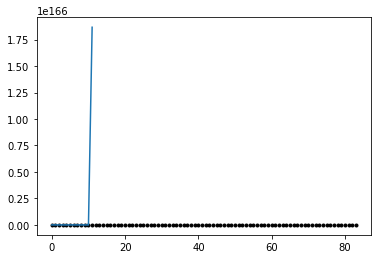

In [71]:
guess = reintegrate(res_1.x, 0.3, 100, split)


plt.plot(country_data, 'k.')
plt.plot(guess)

In [4]:
def nlfunc(x, state, split=None):
    if split:
        [up_coefs, down_coefs] = np.split(x, [split])
    else:
        [up_coefs, down_coefs] = np.split(x, 2)
    up = functools.reduce(lambda a, b: a + state**b[0] * b[1], enumerate(up_coefs), 0)
    down = functools.reduce(lambda a, b: a + state**(b[0]+1) * b[1], enumerate(down_coefs), 1)
    return up/down


def system(x, m2, m1, split=None):
    results = np.zeros_like(m2)
    for i, (a, b) in enumerate(zip(m1, m2)):
        results[i] = (b - nlfunc(x, a, split))**2
    return results.mean()

def reintegrate(x, initial_condition, length, split=None):
    trajectory = [initial_condition]
    for k in range(length):
        trajectory.append(nlfunc(x, trajectory[k], split))
    return np.array(trajectory)